In [1]:
NAME = 'conv-rusentiment'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras

from tensorflow.keras import layers
from tensorflow.keras import losses

import matplotlib.pyplot as plt

import datetime

import mydata as md

data = md.Data('cache')


In [6]:
raw_train_ds, raw_valid_ds, raw_test_ds = data.load('ru-sentiment')

In [7]:
max_features = 20000
sequence_length = 1000

vectorize_layer = keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [8]:
vectorize_layer.adapt(raw_train_ds.map(lambda x,y: x))

2024-06-10 11:53:32.324041: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
train_ds = data.vectorize(raw_train_ds, vectorize_layer)
valid_ds = data.vectorize(raw_valid_ds, vectorize_layer)
test_ds = data.vectorize(raw_test_ds, vectorize_layer)


In [10]:
train_ds_batch=train_ds.shuffle(len(train_ds), reshuffle_each_iteration=True).batch(64)
valid_ds_batch=valid_ds.batch(64)
test_ds_batch=test_ds.batch(64)


In [11]:
embedding_dim=64

embedding_layer = tf.keras.layers.Embedding(
    input_dim=(max_features),
    output_dim=embedding_dim,
    mask_zero=False
)

model = tf.keras.Sequential([
    keras.Input(shape=(None,), dtype="int64"),
    embedding_layer,
    tf.keras.layers.Conv1D(256, 5, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=None, kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, kernel_regularizer=None, kernel_initializer='he_normal')
])
model.summary()

model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='rmsprop',
              metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 64)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, None, 256)      │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,428,739 (5.45 MB)

 Trainable params: 1,428,739 (5.45 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
checkpoint_filepath = f"models/checkpoint_{NAME}.weights.h5"

log_dir = f"logs/fit-{NAME}/{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}"

epochs = 20
history = model.fit(
    train_ds_batch,
    validation_data=valid_ds_batch,
    epochs=epochs,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_weights_only=True,
            save_best_only=True
        ),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]
)

Epoch 1/20


2024-06-10 11:54:33.361615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 39820 of 189891
2024-06-10 11:54:53.361694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 116425 of 189891
2024-06-10 11:55:13.075461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  83/2968 ━━━━━━━━━━━━━━━━━━━━ 37:30 780ms/step - accuracy: 0.4431 - f1_score: 0.2674 - loss: 1.0746

KeyboardInterrupt: 

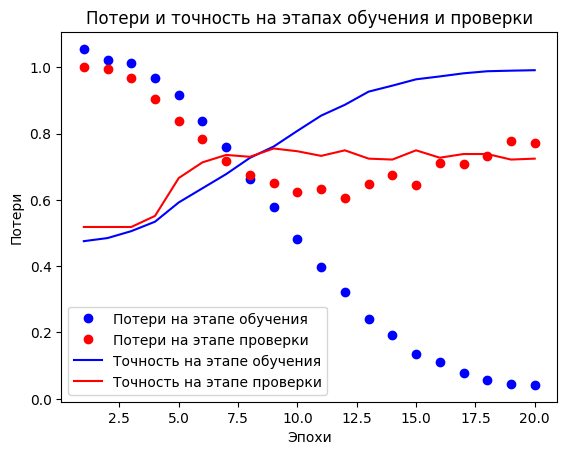

In [97]:
data.plot(history)

In [99]:
model.load_weights(checkpoint_filepath)

In [100]:
model.evaluate(test_ds_batch)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.7271 - f1_score: 0.5871 - loss: 0.6827


[0.6760876178741455, 0.7138888835906982, 0.5791435241699219]

In [81]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  tf.keras.layers.Activation('softmax')
])

export_model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=False), optimizer="rmsprop", metrics=['accuracy', 'F1Score']
)

export_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_3            │ ?                      │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ ?                      │     1,296,707 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,296,707 (4.95 MB)

 Trainable params: 1,296,707 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
export_model.save(f"models/export-model-{NAME}.keras")